aim: Get snp200 stock for australia, create returns metrics and sort them. Long the top decile and short the bottom decile. Make it intra-day too

In [4]:
%load_ext autoreload
%autoreload 2
from base_model_backtest import backtest

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
from pandas_datareader import data as pdr
import sys
sys.path.append('C:/Users/Billy/Documents/PRISMO/Backtester')
from base_model_backtest import backtest
import datetime
import os
from tqdm import tqdm_notebook
import time
import numpy as np
import pickle
from itertools import compress
import matplotlib.pyplot as plt
from math import pi
from matplotlib import rc


In [3]:
indexes = pd.MultiIndex.from_product([asxTickers, ['Open','High','Low','Close','Adj Open','Adj High','Adj Low','Adj Close']])


NameError: name 'asxTickers' is not defined

In [2]:
def pickler(directory, data):
    pickle_out = open(directory,'wb')
    pickle.dump(data,pickle_out)
    pickle_out.close()
    
def dePickler(directory):
    pickle_in = open(directory,'rb')
    return pickle.load(pickle_in)


In [5]:
def pickler(directory, data):
    pickle_out = open(directory,'wb')
    pickle.dump(data,pickle_out)
    pickle_out.close()
    
def dePickler(directory):
    pickle_in = open(directory,'rb')
    return pickle.load(pickle_in)

In [6]:
import pandas as pd
from pandas_datareader import data as pdr
import sys
sys.path.append('C:/Users/Billy/Documents/PRISMO/Backtester')
from base_model_backtest import backtest
import datetime
import os
from tqdm import tqdm_notebook
import time
import numpy as np
import pickle
from itertools import compress
import matplotlib.pyplot as plt


class gapping_1(backtest):
    def __init__(self, 
                timeSeriesClose, 
                timeSeriesLow,
                timeSeriesOpen,
                inIndex,
                toTrade, 
                shape, 
                printBool, 
                plotBool,
                transactionFeesPercent,
                minimumComission ,
                InitialCapital,
                capitalPerTrade,
                decimalPlaces = 10,
                formationPeriod = None, 
                logDir = None,
                stdLookback = 90,
                Zscore = 1
                ):
        # Feeds the selected variables into the __init__ function in the base bactesting model
        # Order of variables is the order they'll be fed into backtest
        super().__init__(timeSeriesClose, 
                toTrade, 
                shape, 
                printBool, 
                plotBool,
                decimalPlaces,
                transactionFeesPercent =transactionFeesPercent,
                minimumComission = minimumComission,
                InitialCapital = InitialCapital,
                logDir=logDir)
        
        
        self.directory = logDir            
        self.features = toTrade    
        #Decimal Places should be assigned globally for transparency
        self.decimalPlaces = decimalPlaces
        
        
        
        
        self.timeSeriesClose = timeSeriesClose
        self.timeSeriesOpen = timeSeriesOpen
        self.timeSeriesLow = timeSeriesLow
        



        self.indexes1 = pd.MultiIndex.from_product([['returns', 'returnsAve20Days'],list(self.features)])
        self.indexes2 = pd.MultiIndex.from_product([['returns', 'returnsStd'+str(stdLookback)+'Days'],list(self.features)])

        
        #Store all returns values
        self.returnsDf = pd.DataFrame(index = self.indexes1)
        self.returnsLowOpenDf = pd.DataFrame(index = self.indexes2)
        self.capitalPerTrade = capitalPerTrade
        
        #Blank template for new row
        self.newRow = pd.DataFrame(index = self.indexes1)

        
        self.stdLookback = stdLookback 
        self.Zscore = Zscore


        self.inIndexDf = inIndex
        self.featuresInIndex = None

    def run(self):

        for index, row in enumerate(self.timeSeriesClose.itertuples()):
            #Close prices in form [date, asset1, asset2, ...]

            closePrices = row
            self.featuresInIndex = [x for x in compress(self.features, self.inIndexDf.iloc[index].tolist())]

            #Close prices in form [date, asset1, asset2, ...]
            openPrices = [pd.DataFrame(self.timeSeriesOpen.iloc[index]).columns[0]] + self.timeSeriesOpen.iloc[index].tolist()

            if index > 1:
                yesterdaysLowPrices = [pd.DataFrame(self.timeSeriesLow.iloc[index-1]).columns[0]] + self.timeSeriesLow.iloc[index-1].tolist()
            else:
                yesterdaysLowPrices = None

            #Create array of open orders to pass into strategy
            if self.orderbook is not None and len(self.orderbook)>0:
                openOrderBook = self.orderbook.loc[self.orderbook['openClosed']=='OPEN']  
            else:
                openOrderBook = None

            #Generate orders
            orders = self.generate_signals(closePrices, openPrices, yesterdaysLowPrices, openOrderBook)



           



    def generate_signals(self, closePriceRow, openPriceRow, yesterdaysLowPriceRow, openOrderBook, closeAll = False):
        
        
        
        ####START OF DAY####
        
        orders = [] 
        date = closePriceRow[0]
        yesterdaysDate = date - pd.DateOffset(1)
    
        #Update price history with the openPrices, as if its a new trading day and all we know is the open prices
        if closeAll != True:
            if self.dfOpenHistory is None:
                self.dfOpenHistory = pd.DataFrame([openPriceRow])
                self.dfOpenHistory.columns = ['Date'] + self.features
                self.dfOpenHistory.set_index(['Date'], inplace=True)
            else:
                temp = pd.DataFrame([openPriceRow])
                temp.columns = ['Date'] + self.features
                temp.set_index(['Date'], inplace=True)
                self.dfOpenHistory = pd.concat([self.dfOpenHistory, temp]) 
                
            if yesterdaysLowPriceRow is not None:
                if self.dfLowHistory is None:
                    self.dfLowHistory = pd.DataFrame([yesterdaysLowPriceRow])
                    self.dfLowHistory.columns = ['Date'] + self.features
                    self.dfLowHistory.set_index(['Date'], inplace=True)
                else:
                    temp = pd.DataFrame([yesterdaysLowPriceRow])
                    temp.columns = ['Date'] + self.features
                    temp.set_index(['Date'], inplace=True)
                    self.dfLowHistory = pd.concat([self.dfLowHistory, temp]) 
        
    
        #compute the returns from yesterdays low to today's open
        if yesterdaysLowPriceRow is not None:
            returnsLowOpen = [openPrice/yesterdaysLowPriceRow[indexLow+1]-1 for indexLow, openPrice in enumerate(openPriceRow[1:])]
            self.returnsLowOpenDf.loc[('returns',slice(None)), date] = returnsLowOpen
            
            
            
        #compute the returns for the close prices and the standard deviation over the past 90 days
        if self.dfHistory is not None and len(self.dfHistory)>2:
            
            self.returnsDf.loc[('returns',slice(None)), yesterdaysDate] =(self.dfHistory.iloc[-1]/self.dfHistory.iloc[-2]-1).values
        
            #Average of values of returns (close prices) for the last 20 days
            if len(self.returnsDf.columns)>20:
                self.returnsDf.loc[('returnsAve20Days',slice(None)), yesterdaysDate] = self.returnsDf.T.returns.rolling(20).mean().iloc[-1].values
            else:
                self.returnsDf.loc[('returnsAve20Days',slice(None)), yesterdaysDate] = self.returnsDf.T.returns.rolling(len(self.returnsDf.columns)).mean().iloc[-1].values
            
        #Standard Deviation of returns (Low-Open) for the last 90 days
        if self.returnsLowOpenDf is not None and len(self.returnsLowOpenDf.columns)>1:
            if len(self.returnsDf.columns)>self.stdLookback:
                self.returnsLowOpenDf.loc[('returnsStd'+str(self.stdLookback)+'Days',slice(None)), date] = self.returnsLowOpenDf.T.returns.rolling(self.stdLookback).std().iloc[-1].values
            else:
                self.returnsLowOpenDf.loc[('returnsStd'+str(self.stdLookback)+'Days',slice(None)), date] = self.returnsLowOpenDf.T.returns.rolling(len(self.returnsLowOpenDf.columns)).std().iloc[-1].values
        
        
        # select stocks whose returns (from yesterdays low to todays open) are less than one standard deviation (calculated above)
        if self.returnsLowOpenDf is not None and len(self.returnsLowOpenDf.columns)>1:
            gappedStocks = self.returnsLowOpenDf.T.loc[date].returns< -self.Zscore*self.returnsLowOpenDf.T.loc[date]['returnsStd'+str(self.stdLookback)+'Days']
            gappedStocks = gappedStocks[gappedStocks==True].index
            
            #Filter down by stocks that are actually in the index
            gappedStocks = gappedStocks[[x in self.featuresInIndex for x in gappedStocks]]


        gappedAndOpenAboveAve = None
        if self.dfHistory is not None and self.dfOpenHistory is not None and len(self.dfHistory)>20:
            # narrow this list by requiring their open prices to be higher than the 20 day moving average
            aveClose =  self.dfHistory.rolling(20).mean().T.loc[gappedStocks].T.iloc[-1]
            todayOpen = self.dfOpenHistory.T.loc[gappedStocks].T.loc[date]

            gappedAndOpenAboveAve = todayOpen>aveClose
            gappedAndOpenAboveAve = gappedAndOpenAboveAve[gappedAndOpenAboveAve==True].index
        

        buyIndex = None
        #Buy the 10 stocks that have the most negative returns from the previous days low to current open.
        if gappedAndOpenAboveAve is not None:
            if len(gappedAndOpenAboveAve) <=10:
                buyIndex = gappedAndOpenAboveAve
            else:
                buyIndex = self.returnsLowOpenDf.dropna().loc[('returns',gappedAndOpenAboveAve), date].sort_values().iloc[-10:].index.codes[1]
                buyIndex = self.returnsLowOpenDf.index.levels[1][buyIndex]

        
        
        
        #BUY STONKS IN THA LIST
        if buyIndex is not None:
            for buyTick in buyIndex:
                price = self.dfOpenHistory[buyTick].iloc[-1]
                quantity = float(self.capitalPerTrade/price)
                if np.isnan(price) or np.isnan(quantity):
                        pass
                else:
                    orders.append([None, 'BUY',  buyTick,  quantity, price, date, 'OPEN'])
        
        #Tick orders here. This is necessary as we want to update the open order book so we can close orders at the market close price
        self.tick(closePriceRow, orders)
        
        #PLOTTING FOR VERIFICATION
        # if len(orders)>0:
        #         for order in orders:
        #             assetSample = order[2]
        #             print(assetSample)

        #             print(self.returnsLowOpenDf.T.loc[date]['returnsStd'+str(self.stdLookback)+'Days'][gappedStocks])
        #             print(self.returnsLowOpenDf.T.loc[date].returns[gappedStocks])
        #             print(self.returnsLowOpenDf.T.loc[date].returns[gappedStocks]<-self.returnsLowOpenDf.T.loc[date]['returnsStd'+str(self.stdLookback)+'Days'][gappedStocks])
        #             lowPrices = self.dfLowHistory[assetSample].iloc[-20:]
        #             openPrices = self.dfOpenHistory[assetSample].iloc[-20:]
        #             plt.plot(lowPrices)
        #             plt.plot(openPrices)
        #             plt.legend(['low','open'])
        #             plt.show()

        ##### TO DELETE #####
        #Help out the thicc memory issues 
        if len(self.returnsDf)>self.stdLookback:
            self.returnsDf = self.returnsDf[self.returnsDf.columns[-(self.stdLookback+1):]]
            self.dfOpenHistory = self.dfOpenHistory.iloc[-(self.stdLookback+1):]
            try:
                self.orderbook = self.orderbook.loc[self.orderbook.openClosed == 'OPEN']
            except Exception as e:
                pass
        
         ####END OF DAY####
            
    
        #Create array of open orders
        if self.orderbook is not None and len(self.orderbook)>0:
            openOrderBook = self.orderbook.loc[self.orderbook['openClosed']=='OPEN']  
        else:
            openOrderBook = None
        
    
    
        
        #Create the orders that we close.
        orders = []
        
        # Close All is true on the last iteration of the loop to close all open trades. Don't want to double-add prices to df histories
        if closeAll != True:
             #Update price history with the close prices
            if self.dfOpenHistory is None:
                self.dfHistory = pd.DataFrame([closePriceRow])
                self.dfHistory.columns = ['Date'] + self.features
                self.dfHistory.set_index(['Date'], inplace=True)
            else:
                temp = pd.DataFrame([closePriceRow])
                temp.columns = ['Date'] + self.features
                temp.set_index(['Date'], inplace=True)
                self.dfHistory = pd.concat([self.dfHistory, temp])  
                
        
        #Sell all stonks that are open
        #Close all open orders on each tick
        if openOrderBook is not None:
            for index, openOrder in openOrderBook.iterrows():
                
                signal = openOrder[1]
                asset = openOrder[2]
                oldDate = openOrder[5]
                quantityTrade = round(openOrder[3], self.decimalPlaces)
                price = round(openOrder[4], self.decimalPlaces)
                orderID = openOrder[0]
                newDate = closePriceRow[0]
                newOrder = None     


                 #IF: date is >=  than buying date + holding period
                if signal == 'SELL':
                    newSignal = 'BUY'
                    newQuantityTrade = -quantityTrade
                    newPrice =  self.dfHistory[asset].iloc[-1]

                    if np.isnan(newPrice) or np.isnan(newQuantityTrade):
                        pass
                    else:
                        #['ID','BUY/SELL','asset','quantity','price','date','OPEN/CLOSED']
                        newOrder = [orderID, newSignal, asset, newQuantityTrade, newPrice, newDate,'CLOSED']
                        orders.append(newOrder)

                if signal == 'BUY':
                    newSignal = 'SELL'
                    newQuantityTrade = -quantityTrade
                    newPrice =  self.dfHistory[asset].iloc[-1]

                    if np.isnan(newPrice) or np.isnan(newQuantityTrade):
                        pass
                    else:
                        #['ID','BUY/SELL','asset','quantity','price','date','OPEN/CLOSED']
                        newOrder = [orderID, newSignal, asset, newQuantityTrade, newPrice, newDate,'CLOSED']
                        orders.append(newOrder)
                        
        #Close orders
        self.tick(closePriceRow, orders)

In [7]:
data = pickle.load(open( "D:/PRISMO/historicalData/data/asx200nobiasInIndexAdded.pickle", "rb" ) )
inIndex = data.xs('inIndex', axis = 1, level = 1).loc['2018-01-01 00:00:00':]
df_close = data.xs('CLOSE', axis = 1, level = 1).loc['2018-01-01 00:00:00':]
df_open = data.xs('OPEN', axis = 1, level = 1).loc['2018-01-01 00:00:00':]
df_low = data.xs('LOW', axis = 1, level = 1).loc['2018-01-01 00:00:00':]


In [8]:
runDate = str(datetime.datetime.today()).replace('-','_').replace(' ','_').replace(':','_')[:-10]
logDirectory = 'D:/PRISMO/logs/ASXgapping1'+ runDate 
try:
    os.makedirs(logDirectory)
except Exception as e:
    print(e)

strat = gapping_1(df_close,
                          df_low,
                          df_open,
                          inIndex,
                          list(df_close.columns),
                          None, 
                          True,
                          True,
                          logDir = logDirectory,
                            transactionFeesPercent = 0,
                            minimumComission = 0,
                            InitialCapital = 0,
                            capitalPerTrade = 1,
                          stdLookback = 90,
                            Zscore = 1)

strat.run()


In [9]:
dates = strat.dfHistory.index
returns = strat.returns.T.reindex(dates, fill_value=0)

In [229]:
def APR(returns):
    ave = []
    for year in range(returns.index[0].year, returns.index[-1].year+1):
        annualReturns = returns.loc[returns.index<str(year+1)+'-01-01']
        annualReturns = annualReturns.loc[annualReturns.index>=str(year)+'-01-01']

        aveReturns = np.mean(annualReturns) 
        ave.append(aveReturns*252*100)
        

    return np.mean(ave)

In [230]:
APR(returns)

26.07108866776966

In [139]:
sharpe(returns)

1.5444911395113028

In [138]:
def sharpe(returns):
    sharpes = []
    for year in range(returns.index[0].year, returns.index[-1].year+1):
        annualReturns = returns.loc[returns.index<str(year+1)+'-01-01']
        annualReturns = annualReturns.loc[annualReturns.index>=str(year)+'-01-01']
        annualReturnsDropZero = annualReturns[annualReturns!=0].dropna()
        daysTraded = len(annualReturnsDropZero)

        aveReturns = np.mean(annualReturnsDropZero) 
        stdReturns = np.std(annualReturnsDropZero)

        sharpes.append(aveReturns/stdReturns*np.sqrt(daysTraded))

    return np.mean(sharpes)

In [122]:
returns.index[0].year

2019

In [120]:
returns.index[-1].year

2019

In [161]:
def beta(returns):
    import statsmodels.api as sm

    riskFree = pdr.get_data_yahoo('^AXJO' , interval = 'd')
    riskFree = riskFree['Adj Close'].pct_change()

    riskFreeReturns = riskFree.reindex(returns.index, fill_value=0).dropna()

    regression = sm.OLS(returns.returns, riskFreeReturns)
    results = regression.fit()

    beta = results.params[0]
    
    return beta

In [162]:
import statsmodels.api as sm


In [182]:
regression = sm.OLS(returns.returns, sm.add_constant(riskFreeReturns))
results = regression.fit()

c:\users\billy\appdata\local\programs\python\python36\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [183]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                returns   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.793
Date:                Mon, 14 Oct 2019   Prob (F-statistic):              0.181
Time:                        13:36:13   Log-Likelihood:                 1499.4
No. Observations:                 448   AIC:                            -2995.
Df Residuals:                     446   BIC:                            -2987.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.252      0.025       0.000       0.002
Adj Close      0.0838      0.063      1.339      0.181      -0.039       0.207
==============================================================================
Omnibus:                      524.999   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52761.362
Skew:                           5.299   Prob(JB):                         0.00
Kurtosis:                      55.098   Cond. No.                         155.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [186]:
results.params[1]

0.08378972182955619

In [200]:
drawdownArray, drawDownDf = drawdowns(returns.returns)
alpha, beta = alpha_beta(returns, '^AXJO')

c:\users\billy\appdata\local\programs\python\python36\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [201]:
drawDownDf

,drawdown
Date,
2018-01-02,0.000000
2018-01-03,0.000000
2018-01-04,0.000000
2018-01-05,0.000000
2018-01-08,0.000000
2018-01-09,0.000000
2018-01-10,0.000000
2018-01-11,0.000000
2018-01-12,0.000000


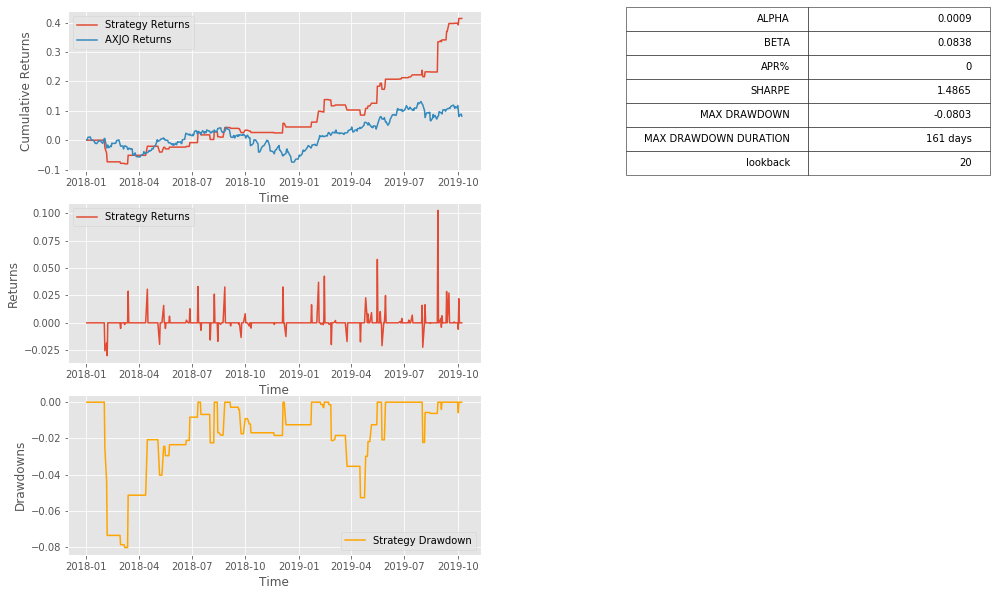

In [221]:
plotResults(dates,
            returns,
            strat.cumulativeCapital,
            '^AXJO',
             None,
            drawdownArray,
            maxDrawDown = round(min(drawdownArray),4),
            maxDrawDownDuration = drawDownLength(drawDownDf),
            alpha = round(alpha,4),
            beta = round(beta,4),
            sharpe = round(sharpe(returns, '^AXJO'),4),
            APR = 0,
            additionalData = [['lookback',str(20)]])

In [222]:
def plotResults(Dates,
                Returns, 
                cumulativeCapital, 
                riskFreeTs, 
                directory,
                drawdownArray, 
                maxDrawDown = 0,
                maxDrawDownDuration = 0,
                alpha = 0,
                beta = 0,
                sharpe = 0,
                APR = 0,
                additionalData = []):

    plt.style.use('ggplot')


    ReturnsHist = Returns[Returns.returns!=0]
    CumulativeReturns = np.cumsum(Returns)
    retHist = [x for x in Returns if x != 0]
    cumulativeCapital = cumulativeCapital.T.reindex(Dates, fill_value=0)
    cumulativeCapital = np.cumsum(cumulativeCapital.values)

    riskFree = pdr.get_data_yahoo(riskFreeTs , interval = 'd')
    riskFree = riskFree['Adj Close'].pct_change()
    riskFreeReturns = riskFree[Dates].dropna()
    riskFreeReturns= riskFreeReturns.reindex(Dates, fill_value=0)
    cumulativeRiskFreeReturns = np.cumsum(riskFreeReturns)


    fig = plt.figure(figsize=(10,10))

    gs = fig.add_gridspec(3,4)

    #Plots for the returns
    returnsCumPlot = fig.add_subplot(gs[0, :-1])
#     returnsCumPlot.set_title('Cumulative Returns')
    returnsCumPlot.set_xlabel('Time')
    returnsCumPlot.set_ylabel('Cumulative Returns')
    returnsCumPlot.plot(Dates, CumulativeReturns)
    returnsCumPlot.plot(Dates, cumulativeRiskFreeReturns)
    returnsCumPlot.legend(['Strategy Returns', 'AXJO Returns'])

    #Plots for the returns
    returnsPlot = fig.add_subplot(gs[1, :-1])
#     returnsPlot.set_title('Returns (strategy only)')
    returnsPlot.set_xlabel('Time')
    returnsPlot.set_ylabel('Returns')
    returnsPlot.plot(Dates, Returns)
    returnsPlot.legend(['Strategy Returns'])


    #Plots for drawdown
    drawdownPlot = fig.add_subplot(gs[2, :-1])
#     drawdownPlot.set_title('Drawdowns')
    drawdownPlot.set_xlabel('Time')
    drawdownPlot.set_ylabel('Drawdowns')
    drawdownPlot.plot(Dates, drawdownArray ,color='orange')
    drawdownPlot.legend(['Strategy Drawdown'])
    
    resultsTable = fig.add_subplot(gs[0, -1:])
    tableContents = [['ALPHA',str(alpha)],
                     ['BETA',str(beta)],
                     ['APR%',str(APR)],
                     ['SHARPE',str(sharpe)],
                     ['MAX DRAWDOWN',str(maxDrawDown)],
                     ['MAX DRAWDOWN DURATION',str(maxDrawDownDuration)+' days']]
    
    tableContents = tableContents + additionalData
    
    resultsTable.table(cellText=tableContents, loc='right',colWidths = [1.5,1.5]).scale(1,2)
    resultsTable.axis('off')
    plt.show()
    
def drawdowns(returns):
    maxVal = None
    cumulativeReturns = []
    drawdownArray = []

    for retVal in returns:
        #Update cumulativeReturns
        if len(cumulativeReturns)>0:
            cumulativeReturns.append(retVal+cumulativeReturns[-1])
        else:
            cumulativeReturns.append(retVal)

        if maxVal is None:
            maxVal = retVal
            drawdownArray.append(0)
        elif cumulativeReturns[-1] > maxVal:
            maxVal=cumulativeReturns[-1]
            drawdownArray.append(0)

        elif cumulativeReturns[-1]<=maxVal:
            drawdownArray.append(drawdownArray[-1]+retVal)


    drawDownDf = pd.DataFrame()    
    drawDownDf['drawdown'] = drawdownArray
    drawDownDf['Date'] = returns.index        
    drawDownDf.set_index(['Date'],inplace=True)

    return drawdownArray, drawDownDf

def drawDownLength(drawDownDf):
    minDrawDownDate = min(drawDownDf[drawDownDf.drawdown == min(drawDownDf.drawdown)].index)
    drawDownStart = max(drawDownDf[drawDownDf.index < minDrawDownDate][drawDownDf[drawDownDf.index < minDrawDownDate]==0].dropna().index)
    drawDownEnd = min(drawDownDf[drawDownDf.index > minDrawDownDate][drawDownDf[drawDownDf.index > minDrawDownDate]==0].dropna().index)
    
    drawDownLen = str(drawDownEnd-drawDownStart)[:-14]
    return drawDownLen

def sharpe(returns, riskFreeTs):
    sharpes = []
    
    riskFree = pdr.get_data_yahoo(riskFreeTs , interval = 'd')
    riskFree = riskFree['Adj Close'].pct_change()
    
    for year in range(returns.index[0].year, returns.index[-1].year+1):
        annualReturns = returns.loc[returns.index<str(year+1)+'-01-01']
        annualReturns = annualReturns.loc[annualReturns.index>=str(year)+'-01-01']
        annualReturnsDropZero = annualReturns[annualReturns!=0].dropna()
        datesTraded = annualReturns.index
        
        riskFreeReturns = riskFree.reindex(datesTraded, fill_value=0).dropna()
        meanriskFreeReturns = np.mean(riskFreeReturns)
        
        daysTraded = len(annualReturnsDropZero)

        aveReturns = np.mean(annualReturnsDropZero) 
        stdReturns = np.std(annualReturnsDropZero)
        sharpes.append((aveReturns-meanriskFreeReturns)/stdReturns*np.sqrt(daysTraded))

    return np.mean(sharpes)



def alpha_beta(returns, riskFreeTs):
    import statsmodels.api as sm

    riskFree = pdr.get_data_yahoo(riskFreeTs , interval = 'd')
    riskFree = riskFree['Adj Close'].pct_change()

    riskFreeReturns = riskFree.reindex(returns.index, fill_value=0).dropna()

    regression = sm.OLS(returns.returns, sm.add_constant(riskFreeReturns))
    results = regression.fit()

    beta = results.params[1]
    alpha = results.params[0]
    
    return alpha, beta

In [77]:
riskFree = pdr.get_data_yahoo(riskFreeTs , interval = 'd')
riskFree = riskFree['Adj Close'].pct_change()
riskFreeReturns = riskFree[Dates].dropna()
riskFreeReturns= riskFreeReturns.reindex(Dates, fill_value=0)
cumulativeRiskFreeReturns = np.cumsum(riskFreeReturns)

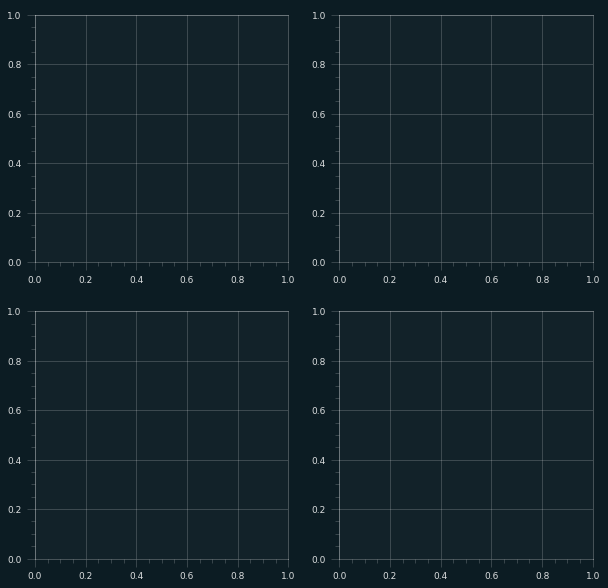

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

In [59]:
fig = plt.figure(figsize = (25,25))

<Figure size 1800x1800 with 0 Axes>

In [61]:
gs = fig.add_gridspec(3,3)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 0:2])
ax3 = fig.add_subplot(gs[1, :])

In [63]:
plt.show()

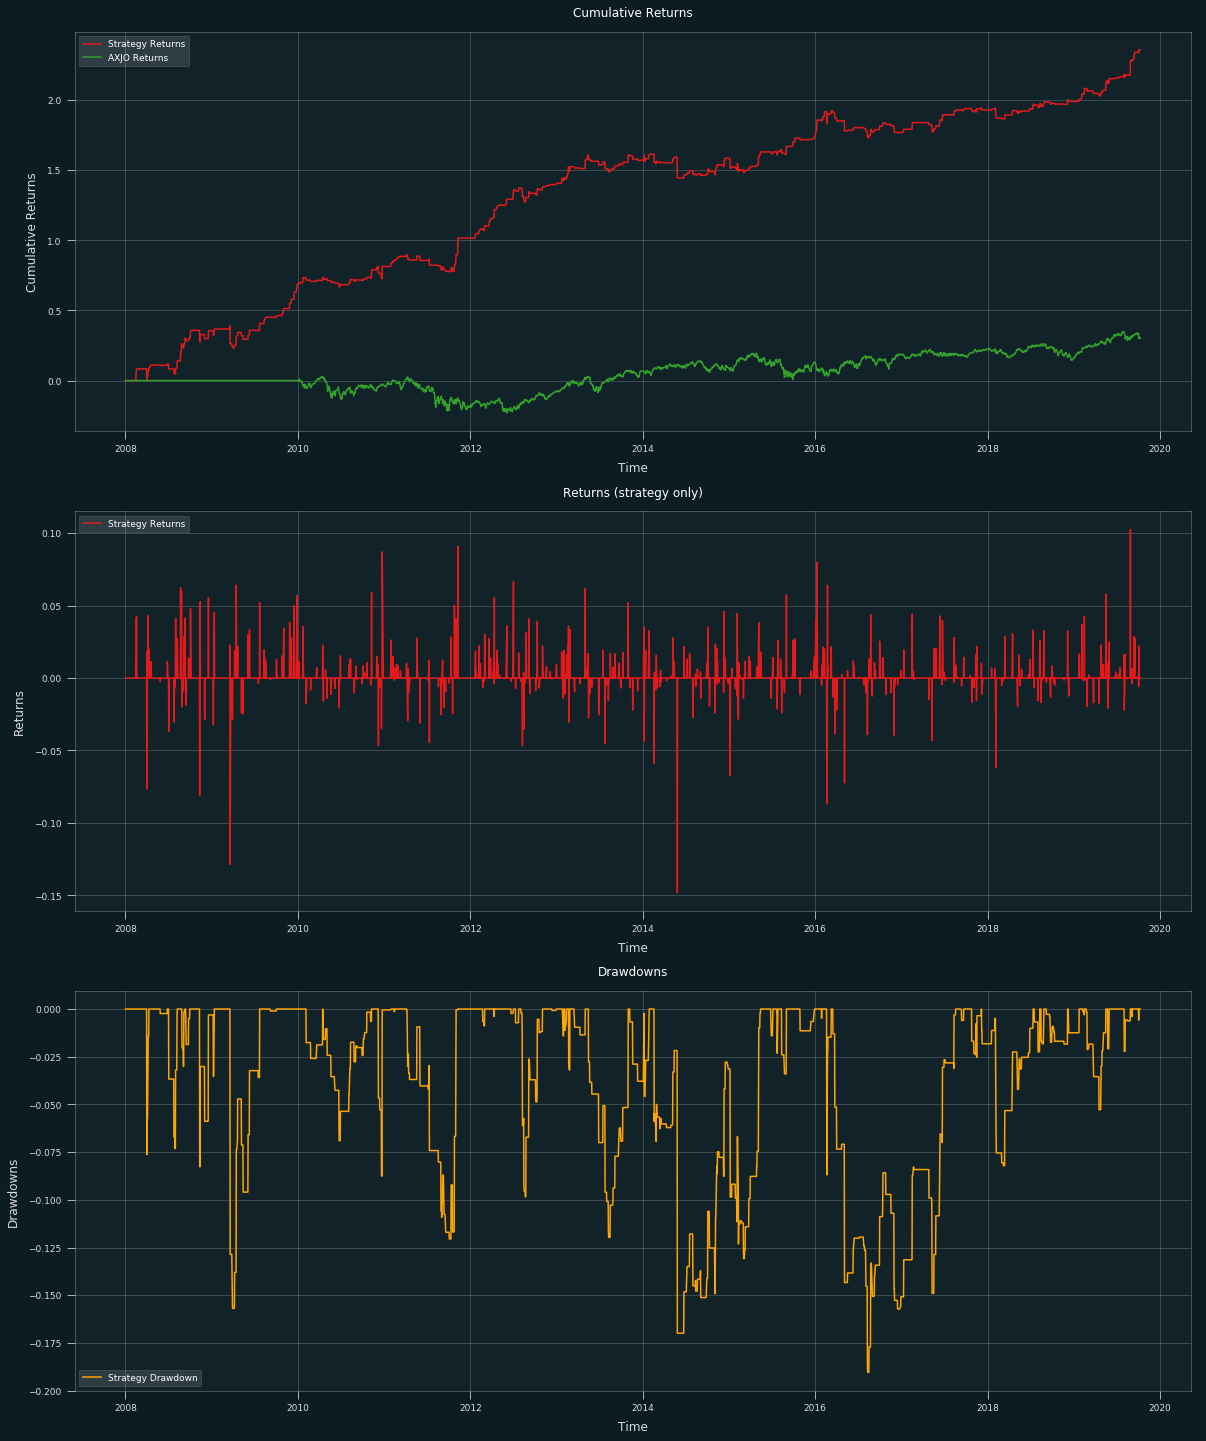

In [143]:
def drawdowns(returns):
    maxVal = None
    cumulativeReturns = []
    drawdownArray = []
    
    for retVal in returns:
        #Update cumulativeReturns
        if len(cumulativeReturns)>0:
            cumulativeReturns.append(retVal+cumulativeReturns[-1])
        else:
            cumulativeReturns.append(retVal)
        
        if maxVal is None:
            maxVal = retVal
            drawdownArray.append(0)
        elif cumulativeReturns[-1] > maxVal:
            maxVal=cumulativeReturns[-1]
            drawdownArray.append(0)
            
        elif cumulativeReturns[-1]<=maxVal:
            drawdownArray.append(drawdownArray[-1]+retVal)
            
    return drawdownArray


fig = plt.figure(figsize=(20,25))

gs = fig.add_gridspec(3,3)

#Plots for the returns
returnsCumPlot = fig.add_subplot(gs[0, :])
returnsCumPlot.set_title('Cumulative Returns')
returnsCumPlot.set_xlabel('Time')
returnsCumPlot.set_ylabel('Cumulative Returns')
returnsCumPlot.plot(Dates, CumulativeReturns)
returnsCumPlot.plot(Dates, cumulativeRiskFreeReturns)
returnsCumPlot.legend(['Strategy Returns', 'AXJO Returns'])

#Plots for the returns
returnsPlot = fig.add_subplot(gs[1, :])
returnsPlot.set_title('Returns (strategy only)')
returnsPlot.set_xlabel('Time')
returnsPlot.set_ylabel('Returns')
returnsPlot.plot(Dates, Returns)
returnsPlot.legend(['Strategy Returns'])


#Plots for drawdown
drawdownPlot = fig.add_subplot(gs[2, :])
drawdownPlot.set_title('Drawdowns')
drawdownPlot.set_xlabel('Time')
drawdownPlot.set_ylabel('Drawdowns')
drawdownPlot.plot(Dates, drawdowns(Returns.returns),color='orange')
drawdownPlot.legend(['Strategy Drawdown'])



plt.show()

In [133]:
def drawdowns(returns):
    maxVal = None
    cumulativeReturns = []
    drawdownArray = []
    
    for retVal in returns:
        #Update cumulativeReturns
        if len(cumulativeReturns)>0:
            cumulativeReturns.append(retVal+cumulativeReturns[-1])
        else:
            cumulativeReturns.append(retVal)
        
        if maxVal is None:
            maxVal = retVal
            drawdownArray.append(0)
        elif cumulativeReturns[-1] > maxVal:
            maxVal=cumulativeReturns[-1]
            drawdownArray.append(0)
            
        elif cumulativeReturns[-1]<=maxVal:
            drawdownArray.append(drawdownArray[-1]+retVal)
        print(maxVal,cumulativeReturns[-1])
            
    return drawdownArray

In [134]:
a = drawdowns(Returns.returns)

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.04100946371599997 0.04100946371599997
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.08364546007296794
0.08364546007296794 0.0836454600

0.4639901937663945 0.4639901937663945
0.4639901937663945 0.4639901937663945
0.4639901937663945 0.4639901937663945
0.4639901937663945 0.4639901937663945
0.4639901937663945 0.4639901937663945
0.4639901937663945 0.4639901937663945
0.4639901937663945 0.4639901937663945
0.4639901937663945 0.4639901937663945
0.4639901937663945 0.4639901937663945
0.4639901937663945 0.4639901937663945
0.4639901937663945 0.4639901937663945
0.4639901937663945 0.4639901937663945
0.4639901937663945 0.4639901937663945
0.4639901937663945 0.4639901937663945
0.4639901937663945 0.4639901937663945
0.4639901937663945 0.4639901937663945
0.47943644750539444 0.47943644750539444
0.47943644750539444 0.47943644750539444
0.47943644750539444 0.47943644750539444
0.47943644750539444 0.47943644750539444
0.5139014314986551 0.5139014314986551
0.5139014314986551 0.5139014314986551
0.5139014314986551 0.5139014314986551
0.5139014314986551 0.5139014314986551
0.5139014314986551 0.5139014314986551
0.5139014314986551 0.5139014314986551
0.51

0.8971758647212159 0.8568807119176155
0.8971758647212159 0.8568807119176155
0.8971758647212159 0.8568807119176155
0.8971758647212159 0.8568807119176155
0.8971758647212159 0.8568807119176155
0.8971758647212159 0.8568807119176155
0.8971758647212159 0.8568807119176155
0.8971758647212159 0.8568807119176155
0.8971758647212159 0.8568807119176155
0.8971758647212159 0.8552811978191531
0.8971758647212159 0.8552811978191531
0.8971758647212159 0.8675717006017816
0.8971758647212159 0.8230024748032756
0.8971758647212159 0.8230024748032756
0.8971758647212159 0.8230024748032756
0.8971758647212159 0.8230024748032756
0.8971758647212159 0.8230024748032756
0.8971758647212159 0.8230024748032756
0.8971758647212159 0.8230024748032756
0.8971758647212159 0.8230024748032756
0.8971758647212159 0.8230024748032756
0.8971758647212159 0.8230024748032756
0.8971758647212159 0.8230024748032756
0.8971758647212159 0.8230024748032756
0.8971758647212159 0.8230024748032756
0.8971758647212159 0.8230024748032756
0.8971758647

1.5261893550845518 1.5261893550845518
1.5261893550845518 1.5166268643371155
1.5261893550845518 1.5166268643371155
1.5261893550845518 1.5166268643371155
1.5261893550845518 1.5166268643371155
1.5261893550845518 1.5166268643371155
1.5261893550845518 1.5166268643371155
1.5261893550845518 1.5166268643371155
1.5261893550845518 1.5166268643371155
1.5261893550845518 1.5166268643371155
1.5261893550845518 1.5166268643371155
1.5261893550845518 1.5166268643371155
1.5261893550845518 1.5166268643371155
1.5261893550845518 1.5166268643371155
1.5261893550845518 1.5166268643371155
1.5261893550845518 1.5166268643371155
1.5261893550845518 1.5125946062727955
1.5261893550845518 1.5125946062727955
1.5261893550845518 1.5125946062727955
1.5261893550845518 1.5125946062727955
1.5261893550845518 1.5125946062727955
1.5261893550845518 1.5125946062727955
1.5261893550845518 1.5125946062727955
1.5261893550845518 1.5125946062727955
1.5261893550845518 1.5125946062727955
1.5261893550845518 1.5125946062727955
1.5261893550

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1.5331578346846833
1.6154595084466479 1.5331578346846833
1.6154595084466479 1.5409166074067404
1.6154595084466479 1.5409166074067404
1.6154595084466479 1.5409166074067404
1.6154595084466479 1.5409166074067404
1.6154595084466479 1.5674035962617405
1.6154595084466479 1.6057014685893272
1.6154595084466479 1.6057014685893272
1.6154595084466479 1.6057014685893272
1.6154595084466479 1.6132344252773272
1.6154595084466479 1.6132344252773272
1.6154595084466479 1.6132344252773272
1.6312849667928628 1.6312849667928628
1.6312849667928628 1.6312849667928628
1.6312849667928628 1.6312849667928628
1.6312849667928628 1.6312849667928628
1.6312849667928628 1.6312849667928628
1.6312849667928628 1.6312849667928628
1.6312849667928628 1.6312849667928628
1.6312849667928628 1.6312849667928628
1.6312849667928628 1.6312849667928628
1.6312849667928628 1.6312849667928628
1.6312849667928628 1.6312849667928628
1.6312849667928628 1.6312849667928628
1.6312849667928628 1.6312849667928628
1.6312849667928628 1.6312849667

1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.7932137451288783
1.9246394926311383 1.8373101306949073
1.9246394926311383 1.8373101306949073
1.9246394926

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2.0493407811670514
2.0847841380890513 2.0493407811670514
2.0847841380890513 2.0493407811670514
2.0847841380890513 2.0493407811670514
2.0847841380890513 2.0493407811670514
2.0847841380890513 2.0493407811670514
2.0847841380890513 2.0493407811670514
2.0847841380890513 2.0320115253745548
2.0847841380890513 2.0320115253745548
2.0847841380890513 2.0320115253745548
2.0847841380890513 2.0320115253745548
2.0847841380890513 2.054877264462555
2.0847841380890513 2.054877264462555
2.0847841380890513 2.063007345762555
2.0847841380890513 2.063007345762555
2.0847841380890513 2.063007345762555
2.0847841380890513 2.063007345762555
2.0847841380890513 2.072314866237555
2.0847841380890513 2.072314866237555
2.0847841380890513 2.072314866237555
2.0847841380890513 2.072314866237555
2.0847841380890513 2.072314866237555
2.0847841380890513 2.072314866237555
2.0847841380890513 2.072314866237555
2.0847841380890513 2.072314866237555
2.130166105914555 2.130166105914555
2.130166105914555 2.130166105914555
2.130166105

In [116]:
plt.plot(np.cumsum())

,returns
Date,
2008-01-02,0.000000
2008-01-03,0.000000
2008-01-04,0.000000
2008-01-07,0.000000
2008-01-08,0.000000
2008-01-09,0.000000
2008-01-10,0.000000
2008-01-11,0.000000
2008-01-14,0.000000


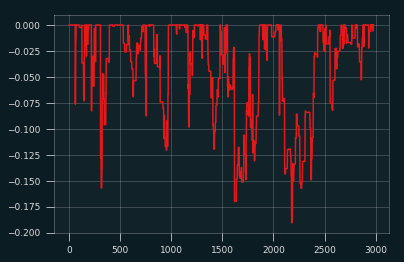

In [135]:
plt.plot(a)

In [107]:
def  plotResultsSummary(Dates, CumulativeReturns, cumulativeCapital, Returns, directory, capitalPerTrade, riskFreeTs, dfHistory):

    #Remove zeros for the histogram
    Returns =  Returns.T.reindex(Dates, fill_value=0)
    ReturnsHist = Returns[Returns.returns!=0].returns
    
    CumulativeReturns = np.cumsum(Returns)
    cumulativeCapital = cumulativeCapital.T.reindex(Dates, fill_value=0)
    cumulativeCapital = np.cumsum(cumulativeCapital.values)

    #Quickly grab the market returns
    plt.style.use(['ggplot'])
    plt.ioff()
    riskFree = pdr.get_data_yahoo(riskFreeTs , interval = 'd')
#     riskFree = riskFree['Adj Close']
#     plt.plot(riskFree['Adj Close'])
    riskFree = riskFree['Adj Close'].pct_change()
    
    # riskFreeReturns = riskFreeReturns[np.abs(riskFreeReturns-riskFreeReturns.mean()) <= 1]
    riskFreeReturns = riskFree[Dates].dropna()

    #Create Plots for analysis
    n, bins, patches = plt.hist(riskFreeReturns.values, 20)
    binsWithZero =sorted(bins.tolist()+[0])
    print(binsWithZero)
    binsWithZero.remove(binsWithZero[binsWithZero.index(0)+1])

    plt.clf()
    #Gotta include 0, delete the proceeding element
    plt.ion()
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0,0].hist(riskFreeReturns, binsWithZero)
    axs[0,0].hist(ReturnsHist, binsWithZero)
    axs[0,0].legend(['Market Returns','Strategy Returns'])
    axs[0,0].set_title('Distribution of Returns')

    axs[1,0].plot(Dates, CumulativeReturns)
    axs[1,0].plot(riskFreeReturns.index, np.cumsum((riskFreeReturns)))
    axs[1,0].legend(['Strategy Returns', 'AXJO Returns'])
    axs[1,0].set_title('Cumulative Returns')
    axs[0,1].plot(Dates, cumulativeCapital)
    axs[0,1].set_title('Capital trading ' + str(capitalPerTrade) +' per trade')
    axs[1,1].plot(Dates, Returns)
    axs[1,1].set_title('Returns')
    plt.show()
    fig.savefig(directory+'/results.jpg')   # save the figure to file
    plt.close(fig)    # close the figure

In [119]:
strat.dfLowHistory.tail()

,ABP,ABC,APT,AGL,ALQ,ALU,AWC,AMC,AMP,ANN,...,WBC,WEB,WES,WHC,WOR,WOW,WPL,WSA,WTC,XRO
Date,,,,,,,,,,,,,,,,,,,,,
2002-11-13,2.043441,2.103548,NaN,NaN,16.172063,1.515173,2.098596,2.430573,2.23903,1.499563,...,2.620474,1.513676,3.263411,NaN,NaN,1.866395,1.908495,1.148671,NaN,NaN
2002-11-14,2.043441,2.103548,NaN,NaN,16.172063,1.515172,2.098596,2.430573,2.23903,1.499563,...,2.620474,1.513676,3.263412,NaN,NaN,1.866394,1.908495,1.148671,NaN,NaN
2002-11-17,2.043441,2.103548,NaN,NaN,16.172065,1.515173,2.098596,2.430573,2.23903,1.499563,...,2.620474,1.513676,3.263411,NaN,NaN,1.866394,1.908495,1.148671,NaN,NaN
2002-11-18,2.043441,2.103548,NaN,NaN,16.172063,1.515173,2.098596,2.430574,2.23903,1.499563,...,2.620474,1.513676,3.263411,NaN,NaN,1.866394,1.908495,1.148671,NaN,NaN
2002-11-19,2.043441,2.103548,NaN,NaN,16.172063,1.515173,2.098596,2.430573,2.23903,1.499563,...,2.620474,1.513676,3.263412,NaN,NaN,1.866394,1.908495,1.148671,NaN,NaN


In [116]:
strat.returnsLowOpenDf

2002-11-13    2002-11-14    2002-11-17  2002-11-18  \
returns          ABP    0.310249  2.283598e-01  2.868513e-01    0.286851   
                 ABC   -0.746888 -7.491476e-01 -7.536675e-01   -0.767227   
                 APT         NaN           NaN           NaN         NaN   
                 AGL         NaN           NaN           NaN         NaN   
                 ALQ   -0.997037 -9.970175e-01 -9.970817e-01   -0.997114   
                 ALU   -0.488032 -4.713836e-01 -4.880318e-01   -0.488032   
                 AWC   -0.224557 -2.235765e-01 -2.078707e-01   -0.209832   
                 AMC    0.056888  6.354347e-02  6.221142e-02    0.072860   
                 AMP    0.762925  8.060603e-01  8.000981e-01    0.837273   
                 ANN    2.192973  2.255231e+00  2.268572e+00    2.246336   
                 ANZ    1.764655  1.803255e+00  1.831028e+00    1.823322   
                 APA   -0.737140 -7.391394e-01 -7.381393e-01   -0.738139   
                 APX         NaN           NaN           NaN         NaN   
                 ARB   -0.117570 -1.175701e-01 -1.333278e-01   -0.164843   
                 ALG         NaN           NaN           NaN         NaN   
                 ALL    0.974747  1.015888e+00  1.077598e+00    1.024116   
                 ASX    1.412690  1.412691e+00  1.417079e+00    1.395135   
                 ALX         NaN           NaN           NaN         NaN   
                 AZJ         NaN           NaN           NaN         NaN   
                 ASL   -0.922738 -9.208070e-01 -9.227382e-01   -0.924669   
                 AST         NaN           NaN           NaN         NaN   
                 ASB   -0.416404 -4.407200e-01 -4.650364e-01   -0.469900   
                 API   -0.507305 -5.110956e-01 -5.073053e-01   -0.512990   
                 AOG    1.229417  1.246179e+00  1.262940e+00    1.246179   
                 BOQ    0.055660  5.875636e-02  4.172943e-02    0.044824   
                 BAP         NaN           NaN           NaN         NaN   
                 BPT   -0.839215 -8.440096e-01 -8.489942e-01   -0.846518   
                 BGA         NaN           NaN           NaN         NaN   
                 BAL         NaN           NaN           NaN         NaN   
                 BEN    0.170787  1.842788e-01  1.767840e-01    0.173786   
...                          ...           ...           ...         ...   
returnsStd90Days SPK         NaN  8.220856e-04  5.919726e-04    0.001319   
                 SSM         NaN           NaN           NaN         NaN   
                 STO         NaN  3.180717e-03  2.597111e-03    0.002831   
                 SUL         NaN           NaN           NaN         NaN   
                 SUN         NaN  1.154022e-02  8.435448e-03    0.012050   
                 SVW         NaN  1.521460e-02  1.739182e-02    0.018717   
                 SXL         NaN           NaN           NaN         NaN   
                 SYD         NaN  2.967500e-03  2.422940e-03    0.002009   
                 TAH         NaN  3.920731e-04  3.201263e-04    0.000416   
                 TCL         NaN  3.048399e-03  6.583984e-03    0.007361   
                 TGR         NaN           NaN           NaN         NaN   
                 TLS         NaN  1.943010e-03  1.399087e-03    0.002696   
                 TNE         NaN  6.441543e-03  4.638440e-03    0.003821   
                 TPM         NaN  2.466666e-03  2.014022e-03    0.001744   
                 TWE         NaN           NaN           NaN         NaN   
                 URW         NaN           NaN           NaN         NaN   
                 VCX         NaN           NaN           NaN         NaN   
                 VEA         NaN           NaN           NaN         NaN   
                 VOC         NaN  0.000000e+00  0.000000e+00    0.000000   
                 VVR         NaN           NaN           NaN         NaN   
                 WBC         NaN  2.863667e-02  3.905843e-02    0.0333

In [30]:
+ pd.DateOffset(1)

Timestamp('1970-01-01 00:00:00.000000001')

In [204]:
df.head()

,ABP,ABC,APT,AGL,ALQ,ALU,AWC,AMC,AMP,ANN,...,WBC,WEB,WES,WHC,WOR,WOW,WPL,WSA,WTC,XRO
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-03,1.264219,1.824164,NaN,NaN,2.577684,0.190223,1.222107,3.593542,4.073546,8.287769,...,14.009808,1.439143,12.077490,4.363514,20.488266,18.785063,30.098234,4.309326,NaN,NaN
2010-01-04,1.292006,1.817482,NaN,NaN,2.594588,0.190223,1.244799,3.518919,4.037174,8.118631,...,14.126109,1.536948,12.235868,4.439036,20.334923,18.671600,30.376842,4.544381,NaN,NaN
2010-01-05,1.292006,1.770709,NaN,NaN,2.639379,0.190223,1.248041,3.518919,4.025052,8.280081,...,14.059650,1.585854,12.054307,4.564907,20.174696,18.638208,30.649107,4.727201,NaN,NaN
2010-01-06,1.305897,1.770709,NaN,NaN,2.687556,0.194027,1.270732,3.484472,3.934124,8.356963,...,13.871377,1.529969,11.861103,4.480993,20.941242,18.598135,30.965773,4.727201,NaN,NaN
2010-01-07,1.272372,1.757345,NaN,NaN,2.696849,0.201636,1.251282,3.536136,3.897753,8.226265,...,13.926739,1.515996,12.154730,4.506167,21.226954,18.758417,30.839104,4.570497,NaN,NaN


In [205]:
ix_ = pd.MultiIndex.from_product([['A'], ['a', 'b', 'c', 'd']])

In [287]:
list(df.columns)

['ABP',
 'ABC',
 'APT',
 'AGL',
 'ALQ',
 'ALU',
 'AWC',
 'AMC',
 'AMP',
 'ANN',
 'ANZ',
 'APA',
 'APX',
 'ARB',
 'ALG',
 'ALL',
 'ASX',
 'ALX',
 'AZJ',
 'ASL',
 'AST',
 'ASB',
 'API',
 'AOG',
 'BOQ',
 'BAP',
 'BPT',
 'BGA',
 'BAL',
 'BEN',
 'BHP',
 'BIN',
 'BKL',
 'BSL',
 'BLD',
 'BXB',
 'BVS',
 'BRG',
 'BKW',
 'BWP',
 'CTX',
 'CAR',
 'CGF',
 'CHC',
 'CQR',
 'CNU',
 'CLW',
 'CIM',
 'CWY',
 'CUV',
 'CCL',
 'COH',
 'COL',
 'CBA',
 'CPU',
 'COE',
 'CTD',
 'CGC',
 'CCP',
 'CMW',
 'CWN',
 'CSL',
 'CSR',
 'CYB',
 'DXS',
 'DHG',
 'DMP',
 'DOW',
 'ECX',
 'ELD',
 'EHL',
 'EHE',
 'EVN',
 'FPH',
 'FBU',
 'FLT',
 'FMG',
 'GUD',
 'GEM',
 'GXY',
 'GMG',
 'GPT',
 'GNC',
 'GOZ',
 'GWA',
 'HVN',
 'HLS',
 'HUB',
 'IEL',
 'ILU',
 'IPL',
 'IGO',
 'ING',
 'IAG',
 'IVC',
 'IFL',
 'IPH',
 'IRE',
 'JHG',
 'JBH',
 'A2M',
 'JHX',
 'LLC',
 'LNK',
 'LYC',
 'MFG',
 'MGR',
 'MIN',
 'MMS',
 'MND',
 'MPL',
 'MQG',
 'MTS',
 'MYX',
 'NAB',
 'NAN',
 'NCM',
 'NEA',
 'NEC',
 'NHC',
 'NHF',
 'NSR',
 'NST',
 'NUF',
 'NWH',


In [65]:
indexes = pd.MultiIndex.from_product([['returns','returnsCum','returnsMean','returnsStd','returnsRiskAdj'],list(df.columns)])

In [323]:
df3 = df

In [89]:
returns_df = pd.DataFrame(index = indexes)

In [325]:
tickers = returns_df.columns.levels[0]

In [327]:
returns_df.returns

,ABP,ABC,APT,AGL,ALQ,ALU,AWC,AMC,AMP,ANN,...,WBC,WEB,WES,WHC,WOR,WOW,WPL,WSA,WTC,XRO


In [347]:
returns_df['Date'] = 'monday'

In [348]:
returns_df.set_index('Date')

Empty DataFrame
Columns: [(returns, ABP), (returns, ABC), (returns, APT), (returns, AGL), (returns, ALQ), (returns, ALU), (returns, AWC), (returns, AMC), (returns, AMP), (returns, ANN), (returns, ANZ), (returns, APA), (returns, APX), (returns, ARB), (returns, ALG), (returns, ALL), (returns, ASX), (returns, ALX), (returns, AZJ), (returns, ASL), (returns, AST), (returns, ASB), (returns, API), (returns, AOG), (returns, BOQ), (returns, BAP), (returns, BPT), (returns, BGA), (returns, BAL), (returns, BEN), (returns, BHP), (returns, BIN), (returns, BKL), (returns, BSL), (returns, BLD), (returns, BXB), (returns, BVS), (returns, BRG), (returns, BKW), (returns, BWP), (returns, CTX), (returns, CAR), (returns, CGF), (returns, CHC), (returns, CQR), (returns, CNU), (returns, CLW), (returns, CIM), (returns, CWY), (returns, CUV), (returns, CCL), (returns, COH), (returns, COL), (returns, CBA), (returns, CPU), (returns, COE), (returns, CTD), (returns, CGC), (returns, CCP), (returns, CMW), (returns, CWN), (returns, CSL), (returns, CSR), (returns, CYB), (returns, DXS), (returns, DHG), (returns, DMP), (returns, DOW), (returns, ECX), (returns, ELD), (returns, EHL), (returns, EHE), (returns, EVN), (returns, FPH), (returns, FBU), (returns, FLT), (returns, FMG), (returns, GUD), (returns, GEM), (returns, GXY), (returns, GMG), (returns, GPT), (returns, GNC), (returns, GOZ), (returns, GWA), (returns, HVN), (returns, HLS), (returns, HUB), (returns, IEL), (returns, ILU), (returns, IPL), (returns, IGO), (returns, ING), (returns, IAG), (returns, IVC), (returns, IFL), (returns, IPH), (returns, IRE), (returns, JHG), (returns, JBH), ...]
Index: []

[0 rows x 1000 columns]

In [102]:
returns_df[df.index[3]] = 66

In [105]:
 #Blank template for new row
newRow2 = pd.DataFrame(index = indexes)
# newRow2.set_index(['Date'], inplace=True)
newRow2.returns = [1]*200

# newRow.index = [df.index[0]]

c:\users\billy\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


In [109]:
newRow2.loc[('returns',slice(None)), df.index[0]] = [6]*200

In [111]:
newRow2.loc[('returnsRiskAdj',slice(None)), df.index[0]] = [99]*200

In [112]:
newRow2

2010-01-03
returns        ABP         6.0
               ABC         6.0
               APT         6.0
               AGL         6.0
               ALQ         6.0
               ALU         6.0
               AWC         6.0
               AMC         6.0
               AMP         6.0
               ANN         6.0
               ANZ         6.0
               APA         6.0
               APX         6.0
               ARB         6.0
               ALG         6.0
               ALL         6.0
               ASX         6.0
               ALX         6.0
               AZJ         6.0
               ASL         6.0
               AST         6.0
               ASB         6.0
               API         6.0
               AOG         6.0
               BOQ         6.0
               BAP         6.0
               BPT         6.0
               BGA         6.0
               BAL         6.0
               BEN         6.0
...                        ...
returnsRiskAdj SPK        99.0
               SSM        99.0
               STO        99.0
               SUL        99.0
               SUN        99.0
               SVW        99.0
               SXL        99.0
               SYD        99.0
               TAH        99.0
               TCL        99.0
               TGR        99.0
               TLS        99.0
               TNE        99.0
               TPM        99.0
               TWE        99.0
               URW        99.0
               VCX        99.0
               VEA        99.0
               VOC        99.0
               VVR        99.0
               WBC        99.0
               WEB        99.0
               WES        99.0
               WHC        99.0
               WOR        99.0
               WOW        99.0
               WPL        99.0
               WSA        99.0
               WTC        99.0
               XRO        99.0

[1000 rows x 1 columns]

In [103]:
pd.concat([returns_df, newRow], axis=1)

2010-01-06  2010-01-03  2010-01-04
returns        ABP          66           1           6
               ABC          66           1           6
               APT          66           1           6
               AGL          66           1           6
               ALQ          66           1           6
               ALU          66           1           6
               AWC          66           1           6
               AMC          66           1           6
               AMP          66           1           6
               ANN          66           1           6
               ANZ          66           1           6
               APA          66           1           6
               APX          66           1           6
               ARB          66           1           6
               ALG          66           1           6
               ALL          66           1           6
               ASX          66           1           6
               ALX          66           1           6
               AZJ          66           1           6
               ASL          66           1           6
               AST          66           1           6
               ASB          66           1           6
               API          66           1           6
               AOG          66           1           6
               BOQ          66           1           6
               BAP          66           1           6
               BPT          66           1           6
               BGA          66           1           6
               BAL          66           1           6
               BEN          66           1           6
...                        ...         ...         ...
returnsRiskAdj SPK          66           1           6
               SSM          66           1           6
               STO          66           1           6
               SUL          66           1           6
               SUN          66           1           6
               SVW          66           1           6
               SXL          66           1           6
               SYD          66           1           6
               TAH          66           1           6
               TCL          66           1           6
               TGR          66           1           6
               TLS          66           1           6
               TNE          66           1           6
               TPM          66           1           6
               TWE          66           1           6
               URW          66           1           6
               VCX          66           1           6
               VEA          66           1           6
               VOC          66           1           6
               VVR          66           1           6
               WBC          66           1           6
               WEB          66           1           6
               WES          66           1           6
               WHC          66           1           6
               WOR          66           1           6
               WOW          66           1           6
               WPL          66           1           6
               WSA          66           1           6
               WTC          66           1           6
               XRO          66           1           6

[1000 rows x 3 columns]

In [319]:
1 == np.nan

False

In [347]:
[x for x in range(1,13)]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [7]:
import requests
from bs4 import BeautifulSoup, NavigableString

url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
page = requests.get(url, headers={'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36'})

soup = BeautifulSoup(page.content, "html5lib")

table = soup.find("table", id="constituents")
print(table.find)

<table class="wikitable sortable" id="constituents">

<tbody><tr>
<th><a href="/wiki/Symbol" title="Symbol">Symbol</a>
</th>
<th>Security</th>
<th><a href="/wiki/SEC_filing" title="SEC filing">SEC filings</a></th>
<th><a href="/wiki/Global_Industry_Classification_Standard" title="Global Industry Classification Standard">GICS</a> Sector</th>
<th>GICS Sub Industry</th>
<th>Headquarters Location</th>
<th>Date first added</th>
<th><a href="/wiki/Central_Index_Key" title="Central Index Key">CIK</a></th>
<th>Founded
</th></tr>
<tr>
<td><a class="external text" href="https://www.nyse.com/quote/XNYS:MMM" rel="nofollow">MMM</a>
</td>
<td><a href="/wiki/3M" title="3M">3M Company</a></td>
<td><a class="external text" href="https://www.sec.gov/cgi-bin/browse-edgar?CIK=MMM&amp;action=getcompany" rel="nofollow">reports</a></td>
<td>Industrials</td>
<td>Industrial Conglomerates</td>
<td><a class="mw-redirect" href="/wiki/St._Paul,_Minnesota" title="St. Paul, Minnesota">St. Paul, Minnesota</a></td>
<t

In [10]:
sandP = pd.read_csv('C:/Users/Billy/Documents/PRISMO/data/ASX/sandP500indexes.csv')

In [14]:
tickers = sandP.TICKER.tolist()

In [15]:
tickers

['ATO',
 'T',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BHGE',
 'BLL',
 'BAC',
 'BK',
 'BAX',
 'BBT',
 'BDX',
 'BRK.B',
 'BBY',
 'BIIB',
 'BLK',
 'HRB',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BF.B',
 'CHRW',
 'COG',
 'CDNS',
 'CPB',
 'COF',
 'CPRI',
 'CAH',
 'KMX',
 'CCL',
 'CAT',
 'CBOE',
 'CBRE',
 'CBS',
 'CDW',
 'CE',
 'CELG',
 'CNC',
 'CNP',
 'CTL',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'XEC',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA',
 'CAG',
 'CXO',
 'COP',
 'ED',
 'STZ',
 'COO',
 'CPRT',
 'GLW',
 'CTVA',
 'COST',
 'COTY',
 'CCI',
 'CSX',
 'CMI',
 'CVS',
 'DHI',
 'DHR',
 'DRI',
 'DVA',
 'DE',
 'DAL',
 'XRAY',
 'DVN',
 'FANG',
 'DLR',
 'DFS',
 'DISCA',
 'DISCK',
 'DISH',
 'DG',
 'DLTR',
 'D',
 'DOV',
 'DOW',
 'DTE',
 'DUK',
 'DRE',
 'DD',
 'DXC',
 'ETFC',
 'EMN',
 'ETN',
 'EBAY',
 'ECL',
 'EIX',
 'EW',
 'EA',
 'EMR',
 'ETR',
 'EOG',
 'EFX',
 'EQIX'

In [16]:
#Fetch adjusted close only
df = None
for ticker in tqdm_notebook(tickers):
    try:
        price = pdr.get_data_yahoo(ticker, start = '2000-01-01')  
        if df is None:
            df = pd.DataFrame(price)
            splitRatios = df['Close']/df['Adj Close']
            df['splits'] = splitRatios
            df['Adj Open'] = df['Open']/splitRatios
            df['Adj Low'] = df['Low']/splitRatios
            df['Adj High'] = df['High']/splitRatios
            print(df.head())
            df.columns = pd.MultiIndex.from_product([[ticker],['High','Low','Open','Close','Volume','Adj Close','Adj Low','Adj High','Adj Open','splits']])
        else:
            df_temp =  pd.DataFrame(price)
            splitRatios = df_temp['Close']/df_temp['Adj Close']
            df_temp['splits'] = splitRatios
            df_temp['Adj Open'] = df_temp['Open']/splitRatios
            df_temp['Adj Low'] = df_temp['Low']/splitRatios
            df_temp['Adj High'] = df_temp['High']/splitRatios
            df_temp.columns = pd.MultiIndex.from_product([[ticker],['High','Low','Open','Close','Volume','Adj Close','Adj Low','Adj High','Adj Open','splits']])
       
            df = df.join(df_temp)
    except Exception as e:
        print(e)

               High      Low     Open    Close    Volume  Adj Close    splits  \
Date                                                                            
1999-12-31  20.4375  19.6250  20.0000  20.4375   47600.0   9.089593  2.248451   
2000-01-03  20.3125  20.0000  20.0000  20.0625   36600.0   8.922815  2.248450   
2000-01-04  20.0000  19.5625  20.0000  19.5625  143800.0   8.700439  2.248450   
2000-01-05  20.5000  19.5625  19.5625  20.1875  251700.0   8.978409  2.248450   
2000-01-06  20.0000  19.7500  20.0000  19.8750   24300.0   8.839424  2.248450   

            Adj Open   Adj Low  Adj High  
Date                                      
1999-12-31  8.895014  8.728233  9.089593  
2000-01-03  8.895018  8.895018  9.034003  
2000-01-04  8.895018  8.700439  8.895018  
2000-01-05  8.700440  8.700440  9.117393  
2000-01-06  8.895018  8.783830  8.895018  
'Date'


KeyboardInterrupt: 